In [1]:
#Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras import layers
from keras.utils import image_dataset_from_directory
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


In [2]:
# Fetch Images count from folders

In [3]:
dirs= os.listdir('Images/')
count=0
for dir in dirs:
    files=list(os.listdir('Images/'+dir))
    print(dir+' Folder has '+str(len(files))+' Images')
    count+=len(files)
print("-"*40)
print("This Folder has Total of "+str(count)+' Images')
print("-"*40)

daisy Folder has 764 Images
dandelion Folder has 1052 Images
rose Folder has 784 Images
sunflower Folder has 733 Images
tulip Folder has 984 Images
----------------------------------------
This Folder has Total of 4317 Images
----------------------------------------


In [4]:
# Loading Images

In [5]:
base_dir='Images/'
img_size=180
batch=32

In [6]:
# Using Keras to load image data from directory and split it into training and validation sets

train_data=keras.utils.image_dataset_from_directory(base_dir,
                                                    seed=123,
                                                    validation_split=0.2,
                                                    subset='training',
                                                    batch_size=batch,
                                                    image_size=(img_size,img_size))
val_data=keras.utils.image_dataset_from_directory(base_dir,
                                                    seed=123,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    batch_size=batch,
                                                    image_size=(img_size,img_size))

##                keras.utils.image_dataset_from_directory
# -This function loads images from a folder and converts them into a dataset that Keras can use for training a model.
# -It automatically labels images based on the subfolder they are in.

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [7]:
flowers_name=train_data.class_names  #This gives the list of flower types(class names) your model will recognize.
flowers_name

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

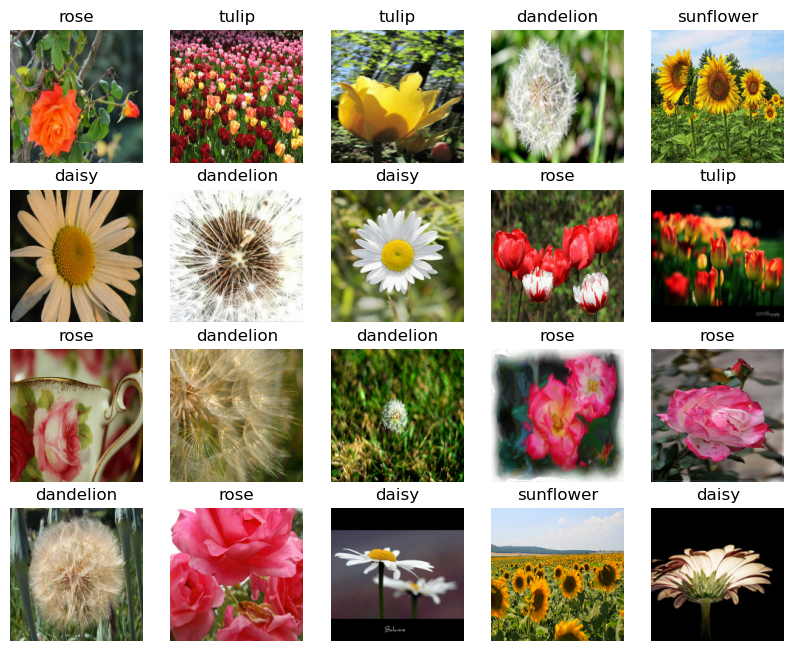

In [8]:
#visualization of some of the images in  training dataset along with their labels.
i=0
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
    for i in range(20):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flowers_name[labels[i]])
        plt.axis('off')

In [9]:
AUTOTUNE= tf.data.AUTOTUNE 
# it means TensorFlow will automatically choose the best number for  buffer size to optimize 
# the performance of data loading and preprocessing at runtime.-> increases efficiency

In [10]:
train_data= train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

#1) Caches the dataset in memory after the first epoch.
#2) Randomly shuffles the dataset to prevent the model from learning any order-based patterns.
#3) 1000 is the buffer size: TensorFlow will randomly shuffle 1000 elements at a time.
#4) Prefetching allows the model to prepare the next batch while training on the current batch, improving performance.

In [11]:
val_data= val_data.cache().prefetch(buffer_size=AUTOTUNE) 
#Since validation data never changes (no shuffling needed)

In [12]:
# Data Augumentation
'''
Data augmentation = “Show the model new edited versions of the same images each epoch”
→ It feels like your dataset is much bigger, but physically it’s not 
'''

'\nData augmentation = “Show the model new edited versions of the same images each epoch”\n→ It feels like your dataset is much bigger, but physically it’s not \n'

In [13]:
data_augmentation = Sequential([
    layers.Input(shape=(img_size, img_size, 3)),   # define input shape here
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


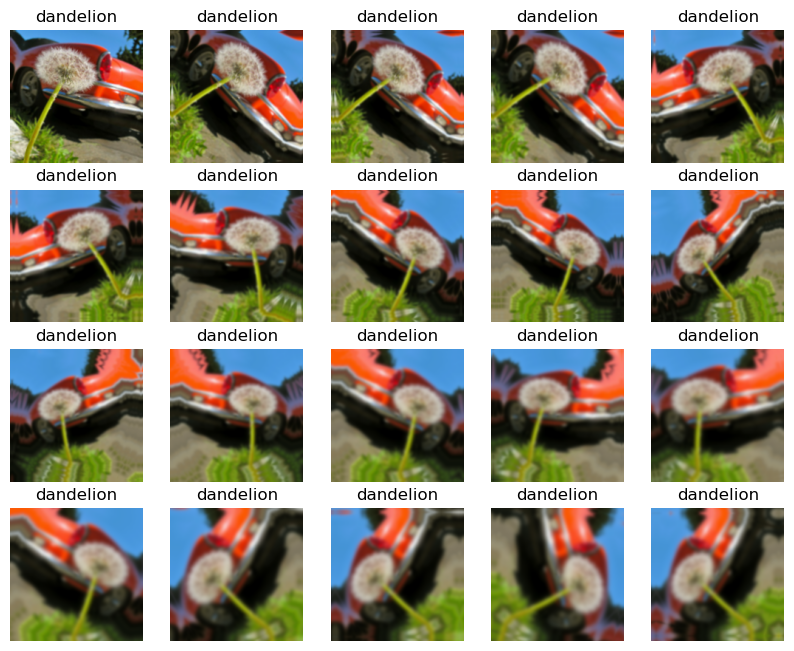

In [14]:
##visualization of new edited versions of the same images of flowers after augmentation

i=0
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
    for i in range(20):
        images=data_augmentation(images)
        plt.subplot(5,5,i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.title(flowers_name[labels[0]])
        plt.axis('off')

# Model Creation

In [15]:
model= Sequential([
    data_augmentation,
    layers.Rescaling(1./255),   # Normalize pixel values (0–255 → 0–1)

    #Conv2D Layers → Act like feature detectors (find edges, colors, textures, shapes).
    #MaxPooling → Shrinks image but keeps important features → reduces complexity.
    
    Conv2D(16,3,padding='same',activation='relu'), 
    MaxPooling2D(),
    Conv2D(32,3,padding='same',activation='relu'),
    MaxPooling2D(),
    Conv2D(64,3,padding='same',activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),         # Randomly drop 20% neurons → prevent overfitting
    Flatten(),            # Convert 2D features → 1D vector
    Dense(128,activation='relu'),
    Dense(5)              # Output 5 values (one for each flower class)
])

In [16]:
#Specify how the model learns and how its performance is measured
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
    metrics=['accuracy']  
)


In [17]:
model.summary()  #Displays summary of Our model architecture.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history=model.fit(train_data,epochs=15,validation_data=val_data)

Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - accuracy: 0.3228 - loss: 1.5093 - val_accuracy: 0.5342 - val_loss: 1.1216
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - accuracy: 0.5668 - loss: 1.0797 - val_accuracy: 0.5713 - val_loss: 1.0918
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.6168 - loss: 0.9812 - val_accuracy: 0.6396 - val_loss: 0.9519
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.6553 - loss: 0.8659 - val_accuracy: 0.6651 - val_loss: 0.8400
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.6684 - loss: 0.8515 - val_accuracy: 0.6709 - val_loss: 0.8289
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step - accuracy: 0.6863 - loss: 0.8298 - val_accuracy: 0.6408 - val_loss: 0.9420
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - accuracy: 0.7078 - loss: 0.7504 - val_accuracy: 0.7173 - val_loss: 0.7557
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 221ms/step - accuracy: 0.7311 - loss: 0

In [19]:
def classify_images(image_path):
    input_image=tf.keras.utils.load_img(image_path,target_size=(180,180))
                      # Load the image and resize it to 180x180 pixels
    input_image_array=tf.keras.utils.img_to_array(input_image)
                       # Converts the image into a numeric array 
    input_image_exp_dim=tf.expand_dims(input_image_array,0)
                       # packs your single image into a batch, so the model can accept it.
    predictions = model.predict(input_image_exp_dim)
                      # Passes the image through the CNN.
    result=tf.nn.softmax(predictions[0])
                      # Converts raw scores → probabilities (between 0 and 1).
    outcome= 'The Image belongs to ' + flowers_name[np.argmax(result)]+' with a score of '+str(np.max(result)*100)
    return outcome

In [ ]:
classify_images('Sample/daisy.jpg')

In [ ]:
model.save('Flower_Recognition_Model.keras')


In [1]:
%%writefile app.py
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import load_model
import streamlit as st

st.set_page_config(
    page_title="Flower Recognition App",
    page_icon="🌸",
    layout="centered"
)
st.markdown(
    """
    <style>
    .stApp {
        background-image: url("https://c4.wallpaperflare.com/wallpaper/295/401/83/flowers-background-dark-patterns-wallpaper-preview.jpg");
        background-size: cover;
        background-position: center;
    }
    </style>
    """,
    unsafe_allow_html=True
)
st.markdown("<h1 style='text-align: center; color: white;'>🌸 Flower Recognition CNN Model</h1>", unsafe_allow_html=True)
flowers_name=['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

model=load_model('Flower_Recognition_Model.keras')

def classify_images(image_path):
    input_image=tf.keras.utils.load_img(image_path,target_size=(180,180))
    input_image_array=tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim=tf.expand_dims(input_image_array,0)
    predictions = model.predict(input_image_exp_dim)
    result=tf.nn.softmax(predictions[0])
    outcome= 'The Image belongs to ' + flowers_name[np.argmax(result)]+' with a score of '+str(np.max(result)*100)
    return outcome

upload_file=st.file_uploader('Upload an Image',type=["jpg", "png", "jpeg"])
if upload_file is not None:
    # Ensure upload folder exists
    if not os.path.exists('upload'):
        os.makedirs('upload')
    file_path = os.path.join('upload', upload_file.name)
    # Save uploaded file
    with open(file_path, 'wb') as f:
        f.write(upload_file.getbuffer())
    # Classify the image
    st.image(upload_file,width=200)
    st.markdown(classify_images(file_path))
   
else:
    st.info("Please upload an image to classify.")

Overwriting app.py


In [ ]:
!streamlit run app.py 